## Training for Task 2

In [1]:
# Load dependencies!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

The shape of the mitbih_train is :  (87554, 188)
The shape of the mitbih_test is :  (21892, 188)
The last time value is :  1488.0


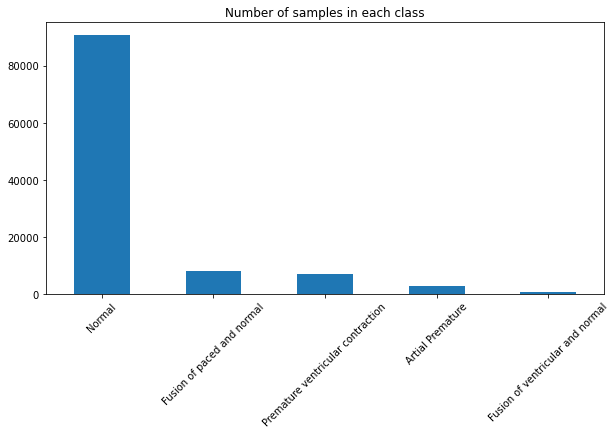

In [4]:
df_mitbih_train = pd.read_csv("../Datasets/ecg_dataset/mitbih_train.csv", header = None)
df_mitbih_test = pd.read_csv("../Datasets/ecg_dataset/mitbih_test.csv", header = None)

# print shapes of the dataframes
print("The shape of the mitbih_train is : ", df_mitbih_train.shape)
print("The shape of the mitbih_test is : ", df_mitbih_test.shape)

df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
#df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_mitbih.shape[1] - 1 
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_mitbih.columns = list(time) + ["label"]

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_mitbih["label"].value_counts()
# substitute the class names
counts.index = counts.index.map(id_to_label)
# create a figure 
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 45)
plt.title("Number of samples in each class")
plt.show()

In [3]:
# Let's convert this to a datatype which is easy to work with: Numpy! or Torch Tensors!

# Converting the normal data to numpy
train_dataset = df_mitbih_train.to_numpy()

test_dataset = df_mitbih_test.to_numpy()

# Making sure the data in numpy is the same as the data in the pandas dataframe
print(train_dataset.shape)

print(test_dataset.shape)

(87554, 188)
(21892, 188)


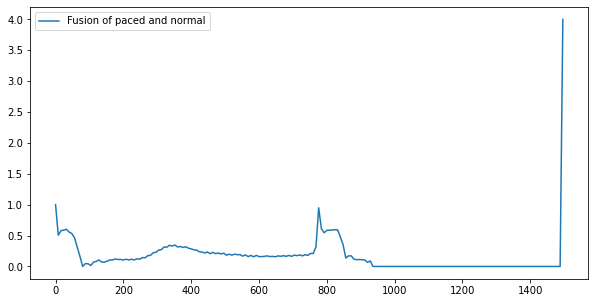

In [14]:
# Let's see if it worked
time = np.arange(train_dataset.shape[1])*1000/125
index = 85000
label = id_to_label[train_dataset[index,-1]]
    
plt.figure(figsize = (10, 5))
plt.plot(time, train_dataset[index,:], label=label)
plt.legend()
plt.show()

# I think it did, no ?

In [21]:
# Now let's separate the data from the labels

# For training
X_train_dataset = train_dataset[:,:-1]
Y_train_dataset = train_dataset[:,-1]


np.random.shuffle(X_train_dataset)
np.random.shuffle(Y_train_dataset)

# For testing
X_test_dataset = test_dataset[:,:-1]
Y_test_dataset = test_dataset[:,-1]

# Let's load it into Pytorch

# Loading the input data
X_torch_train_dataset = torch.from_numpy(X_train_dataset)

# Loading the output labels


# But first, we need to convert them to one hot encodings
Y_torch_train_dataset = torch.from_numpy(Y_train_dataset).type(torch.LongTensor)

# Declare the batch_size for training
batch_size = 32

# And split them into batches
XsplitBatch = list(torch.split(X_torch_train_dataset, X_torch_train_dataset.shape[0]//batch_size))
YsplitBatch = list(torch.split(Y_torch_train_dataset, Y_torch_train_dataset.shape[0]//batch_size))


# print their shapes
print(X_torch_train_dataset.shape)
print(Y_torch_train_dataset.shape)

torch.Size([87554, 187])
torch.Size([87554])


In [22]:
# What if I train a neural network to train on the data

class Network(nn.Module):
    def __init__(self, inpDim, outDim):
        super().__init__()
        self.LinearStack = nn.Sequential(
            nn.Linear(inpDim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 8),
            nn.ReLU(),
            nn.Linear(8, 5),
            nn.ReLU(),
            nn.Linear(5, outDim)
        )
        
    def forward(self, inp):
        return F.log_softmax(self.LinearStack(inp), dim=1)

In [26]:
# Define the model, optimizer, loss function etc

# Define the input_dim}
input_dim = X_torch_train_dataset.shape[1]

# Define the output_dim 
output_dim = 5

# Declare the model object
model = Network(inpDim=X_torch_train_dataset.shape[1], outDim=output_dim)

# Initializing the optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

# Printing interval
interval = 1

# number of epochs
n_epochs = 100

In [27]:
# Let's train I guess ?
Testing_accuracy = []
for epoch in range(n_epochs):
    print('Epoch: ', epoch+1)
    for i, (x_batch, y_batch) in enumerate(zip(XsplitBatch, YsplitBatch)):
        y_pred = model(x_batch.float())
        
        loss = F.nll_loss(y_pred, y_batch)
        if i % interval == 0:
            with torch.no_grad():
                y_test_pred = model(torch.from_numpy(X_test_dataset).float())
                test_loss = F.nll_loss(y_test_pred, torch.from_numpy(Y_test_dataset).type(torch.LongTensor), size_average=False).item()
                pred = y_test_pred.data.max(1, keepdim=True)[1]
                correct = (torch.from_numpy(Y_test_dataset).type(torch.LongTensor) == pred.reshape(-1)).sum()
                accuracy = correct/X_test_dataset.shape[0] * 100
                Testing_accuracy.append(accuracy)
                print('Accuracy {} %    Test Loss: {}'.format(accuracy, test_loss), end = '   ')

            print('Loss: ', loss.item())
            (torch.from_numpy(Y_test_dataset).type(torch.LongTensor) == pred.reshape(-1)).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    

Epoch:  1
Accuracy 6.614288806915283 %    Test Loss: 41389.703125   Loss:  1.8935941457748413
Accuracy 6.614288806915283 %    Test Loss: 41210.2734375   Loss:  1.883141040802002
Accuracy 5.015530586242676 %    Test Loss: 41032.59765625   Loss:  1.8719866275787354
Accuracy 0.7125890851020813 %    Test Loss: 40830.6171875   Loss:  1.8625829219818115
Accuracy 0.7399963736534119 %    Test Loss: 40585.078125   Loss:  1.8544667959213257
Accuracy 0.7399963736534119 %    Test Loss: 40266.9453125   Loss:  1.840214729309082
Accuracy 0.7445642352104187 %    Test Loss: 39903.59765625   Loss:  1.817731499671936
Accuracy 0.8359218239784241 %    Test Loss: 39496.4453125   Loss:  1.795700192451477
Accuracy 1.9596199989318848 %    Test Loss: 39004.296875   Loss:  1.7721707820892334
Accuracy 2.480358123779297 %    Test Loss: 38399.1953125   Loss:  1.7405790090560913
Accuracy 2.4027042388916016 %    Test Loss: 37726.375   Loss:  1.6849217414855957
Accuracy 2.535172700881958 %    Test Loss: 37188.50390625

Accuracy 82.76082611083984 %    Test Loss: 23579.744140625   Loss:  1.007811188697815
Accuracy 82.76082611083984 %    Test Loss: 23404.41796875   Loss:  1.0191547870635986
Accuracy 82.76082611083984 %    Test Loss: 23254.814453125   Loss:  0.3550524115562439
Epoch:  4
Accuracy 82.76082611083984 %    Test Loss: 23464.25   Loss:  1.0516682863235474
Accuracy 82.76082611083984 %    Test Loss: 23710.935546875   Loss:  1.0488194227218628
Accuracy 82.76082611083984 %    Test Loss: 23634.29296875   Loss:  1.025298833847046
Accuracy 82.76082611083984 %    Test Loss: 23252.3984375   Loss:  1.0131752490997314
Accuracy 82.76082611083984 %    Test Loss: 22780.4375   Loss:  1.0241107940673828
Accuracy 82.76082611083984 %    Test Loss: 22425.697265625   Loss:  1.0072818994522095
Accuracy 82.76082611083984 %    Test Loss: 22277.08984375   Loss:  0.9473130106925964
Accuracy 82.76082611083984 %    Test Loss: 22205.1328125   Loss:  1.0055899620056152
Accuracy 82.76082611083984 %    Test Loss: 22131.43164

Accuracy 82.76082611083984 %    Test Loss: 17871.060546875   Loss:  0.7916803956031799
Accuracy 82.76082611083984 %    Test Loss: 17823.423828125   Loss:  0.8161786794662476
Accuracy 82.76082611083984 %    Test Loss: 17772.623046875   Loss:  0.7802359461784363
Accuracy 82.76082611083984 %    Test Loss: 17721.328125   Loss:  0.773182213306427
Accuracy 82.76082611083984 %    Test Loss: 17703.521484375   Loss:  0.7822200655937195
Accuracy 82.76082611083984 %    Test Loss: 17733.75390625   Loss:  0.1433742642402649
Epoch:  7
Accuracy 82.76082611083984 %    Test Loss: 18244.853515625   Loss:  0.829689621925354
Accuracy 82.76082611083984 %    Test Loss: 18565.599609375   Loss:  0.8405546545982361
Accuracy 82.76082611083984 %    Test Loss: 18235.298828125   Loss:  0.8050581812858582
Accuracy 82.76082611083984 %    Test Loss: 17657.544921875   Loss:  0.7891676425933838
Accuracy 82.76082611083984 %    Test Loss: 17332.673828125   Loss:  0.8052165508270264
Accuracy 82.76082611083984 %    Test Lo

Accuracy 82.76082611083984 %    Test Loss: 15952.166015625   Loss:  0.7272275686264038
Accuracy 82.76082611083984 %    Test Loss: 15903.1630859375   Loss:  0.7500384449958801
Accuracy 82.76082611083984 %    Test Loss: 15838.201171875   Loss:  0.7030773162841797
Accuracy 82.76082611083984 %    Test Loss: 15808.6103515625   Loss:  0.7353677153587341
Accuracy 82.76082611083984 %    Test Loss: 15787.9150390625   Loss:  0.7055744528770447
Accuracy 82.76082611083984 %    Test Loss: 15764.7177734375   Loss:  0.7236378788948059
Accuracy 82.76082611083984 %    Test Loss: 15734.6328125   Loss:  0.6987226009368896
Accuracy 82.76082611083984 %    Test Loss: 15722.8662109375   Loss:  0.6863120198249817
Accuracy 82.76082611083984 %    Test Loss: 15748.74609375   Loss:  0.6958582401275635
Accuracy 82.76082611083984 %    Test Loss: 15791.6318359375   Loss:  0.0931195467710495
Epoch:  10
Accuracy 82.76082611083984 %    Test Loss: 16181.904296875   Loss:  0.7388752102851868
Accuracy 82.76082611083984 % 

Accuracy 82.76082611083984 %    Test Loss: 14941.0380859375   Loss:  0.6827366352081299
Accuracy 82.76082611083984 %    Test Loss: 14972.810546875   Loss:  0.7016061544418335
Accuracy 82.76082611083984 %    Test Loss: 15011.1826171875   Loss:  0.6718873381614685
Accuracy 82.76082611083984 %    Test Loss: 15032.083984375   Loss:  0.6904733777046204
Accuracy 82.76082611083984 %    Test Loss: 15012.1689453125   Loss:  0.6877424716949463
Accuracy 82.76082611083984 %    Test Loss: 14977.748046875   Loss:  0.7080305814743042
Accuracy 82.76082611083984 %    Test Loss: 14946.61328125   Loss:  0.6650260090827942
Accuracy 82.76082611083984 %    Test Loss: 14936.9736328125   Loss:  0.6958569884300232
Accuracy 82.76082611083984 %    Test Loss: 14924.03125   Loss:  0.6675684452056885
Accuracy 82.76082611083984 %    Test Loss: 14907.1337890625   Loss:  0.6814804077148438
Accuracy 82.76082611083984 %    Test Loss: 14893.412109375   Loss:  0.6652030348777771
Accuracy 82.76082611083984 %    Test Loss: 

Accuracy 82.76082611083984 %    Test Loss: 14560.8427734375   Loss:  0.6789475083351135
Accuracy 82.76082611083984 %    Test Loss: 14591.015625   Loss:  0.6519099473953247
Accuracy 82.76082611083984 %    Test Loss: 14608.302734375   Loss:  0.6818718910217285
Accuracy 82.76082611083984 %    Test Loss: 14600.3740234375   Loss:  0.6883537173271179
Accuracy 82.76082611083984 %    Test Loss: 14595.1064453125   Loss:  0.6845393776893616
Accuracy 82.76082611083984 %    Test Loss: 14611.8505859375   Loss:  0.6643263101577759
Accuracy 82.76082611083984 %    Test Loss: 14653.0322265625   Loss:  0.6864906549453735
Accuracy 82.76082611083984 %    Test Loss: 14682.4033203125   Loss:  0.6558219790458679
Accuracy 82.76082611083984 %    Test Loss: 14691.921875   Loss:  0.6739075779914856
Accuracy 82.76082611083984 %    Test Loss: 14672.521484375   Loss:  0.6730427742004395
Accuracy 82.76082611083984 %    Test Loss: 14651.1259765625   Loss:  0.6916927695274353
Accuracy 82.76082611083984 %    Test Loss:

Accuracy 82.76082611083984 %    Test Loss: 14505.6826171875   Loss:  0.6694573760032654
Accuracy 82.76082611083984 %    Test Loss: 14610.556640625   Loss:  0.6415361762046814
Accuracy 82.76082611083984 %    Test Loss: 14643.6982421875   Loss:  0.6693663597106934
Accuracy 82.76082611083984 %    Test Loss: 14566.5732421875   Loss:  0.6756550669670105
Accuracy 82.76082611083984 %    Test Loss: 14488.3564453125   Loss:  0.6565306186676025
Accuracy 82.76082611083984 %    Test Loss: 14484.5537109375   Loss:  0.6735402345657349
Accuracy 82.76082611083984 %    Test Loss: 14516.509765625   Loss:  0.6467989683151245
Accuracy 82.76082611083984 %    Test Loss: 14527.6123046875   Loss:  0.6765483021736145
Accuracy 82.76082611083984 %    Test Loss: 14519.5087890625   Loss:  0.6829027533531189
Accuracy 82.76082611083984 %    Test Loss: 14521.736328125   Loss:  0.6787973642349243
Accuracy 82.76082611083984 %    Test Loss: 14544.9833984375   Loss:  0.6579331159591675
Accuracy 82.76082611083984 %    Tes

Accuracy 82.76082611083984 %    Test Loss: 14361.2275390625   Loss:  0.6695788502693176
Accuracy 82.76082611083984 %    Test Loss: 14400.7197265625   Loss:  0.6520872116088867
Accuracy 82.76082611083984 %    Test Loss: 14421.873046875   Loss:  0.6224291324615479
Accuracy 82.76082611083984 %    Test Loss: 14385.0888671875   Loss:  0.6524343490600586
Accuracy 82.76082611083984 %    Test Loss: 14400.18359375   Loss:  0.6509712338447571
Accuracy 82.76082611083984 %    Test Loss: 14497.2255859375   Loss:  0.6677690744400024
Accuracy 82.76082611083984 %    Test Loss: 14578.9521484375   Loss:  0.6409723162651062
Accuracy 82.76082611083984 %    Test Loss: 14586.1826171875   Loss:  0.667725682258606
Accuracy 82.76082611083984 %    Test Loss: 14506.580078125   Loss:  0.6728484034538269
Accuracy 82.76082611083984 %    Test Loss: 14444.3662109375   Loss:  0.6554150581359863
Accuracy 82.76082611083984 %    Test Loss: 14450.1103515625   Loss:  0.6723264455795288
Accuracy 82.76082611083984 %    Test 

Accuracy 82.76082611083984 %    Test Loss: 14483.8076171875   Loss:  0.05954888463020325
Epoch:  24
Accuracy 82.76082611083984 %    Test Loss: 14628.966796875   Loss:  0.6646243333816528
Accuracy 82.76082611083984 %    Test Loss: 14660.4228515625   Loss:  0.6740537285804749
Accuracy 82.76082611083984 %    Test Loss: 14515.8056640625   Loss:  0.6451736092567444
Accuracy 82.76082611083984 %    Test Loss: 14375.390625   Loss:  0.6501373052597046
Accuracy 82.76082611083984 %    Test Loss: 14332.638671875   Loss:  0.668983519077301
Accuracy 82.76082611083984 %    Test Loss: 14358.5048828125   Loss:  0.6504409909248352
Accuracy 82.76082611083984 %    Test Loss: 14371.7421875   Loss:  0.620094358921051
Accuracy 82.76082611083984 %    Test Loss: 14353.79296875   Loss:  0.6504066586494446
Accuracy 82.76082611083984 %    Test Loss: 14400.00390625   Loss:  0.6504040360450745
Accuracy 82.76082611083984 %    Test Loss: 14505.8310546875   Loss:  0.6674619913101196
Accuracy 82.76082611083984 %    Tes

Accuracy 82.76082611083984 %    Test Loss: 14534.3642578125   Loss:  0.6547664999961853
Accuracy 82.76082611083984 %    Test Loss: 14524.982421875   Loss:  0.6511750817298889
Accuracy 82.76082611083984 %    Test Loss: 14510.1064453125   Loss:  0.6287304162979126
Accuracy 82.76082611083984 %    Test Loss: 14496.8125   Loss:  0.6348519921302795
Accuracy 82.76082611083984 %    Test Loss: 14485.9697265625   Loss:  0.05529170110821724
Epoch:  27
Accuracy 82.76082611083984 %    Test Loss: 14622.7294921875   Loss:  0.6628725528717041
Accuracy 82.76082611083984 %    Test Loss: 14662.2509765625   Loss:  0.6722450852394104
Accuracy 82.76082611083984 %    Test Loss: 14531.2880859375   Loss:  0.6444818377494812
Accuracy 82.76082611083984 %    Test Loss: 14393.7841796875   Loss:  0.6501200795173645
Accuracy 82.76082611083984 %    Test Loss: 14344.07421875   Loss:  0.6685564517974854
Accuracy 82.76082611083984 %    Test Loss: 14360.2041015625   Loss:  0.6496813297271729
Accuracy 82.76082611083984 % 

Accuracy 82.76082611083984 %    Test Loss: 14464.21875   Loss:  0.6836802363395691
Accuracy 82.76082611083984 %    Test Loss: 14462.7099609375   Loss:  0.6432193517684937
Accuracy 82.76082611083984 %    Test Loss: 14474.28125   Loss:  0.6736199259757996
Accuracy 82.76082611083984 %    Test Loss: 14467.3095703125   Loss:  0.6438533067703247
Accuracy 82.76082611083984 %    Test Loss: 14466.3369140625   Loss:  0.6545388102531433
Accuracy 82.76082611083984 %    Test Loss: 14451.0087890625   Loss:  0.6503605842590332
Accuracy 82.76082611083984 %    Test Loss: 14438.2080078125   Loss:  0.6279129385948181
Accuracy 82.76082611083984 %    Test Loss: 14435.21484375   Loss:  0.634248673915863
Accuracy 82.76082611083984 %    Test Loss: 14439.7783203125   Loss:  0.04930643364787102
Epoch:  30
Accuracy 82.76082611083984 %    Test Loss: 14585.337890625   Loss:  0.6619957685470581
Accuracy 82.76082611083984 %    Test Loss: 14639.6865234375   Loss:  0.6714543104171753
Accuracy 82.76082611083984 %    Te

Accuracy 82.76082611083984 %    Test Loss: 14492.6689453125   Loss:  0.653111457824707
Accuracy 82.76082611083984 %    Test Loss: 14469.8447265625   Loss:  0.6802830696105957
Accuracy 82.76082611083984 %    Test Loss: 14465.0390625   Loss:  0.6483134031295776
Accuracy 82.76082611083984 %    Test Loss: 14471.2783203125   Loss:  0.6657516956329346
Accuracy 82.76082611083984 %    Test Loss: 14473.0703125   Loss:  0.6671041250228882
Accuracy 82.76082611083984 %    Test Loss: 14485.181640625   Loss:  0.6829841732978821
Accuracy 82.76082611083984 %    Test Loss: 14490.228515625   Loss:  0.6419245600700378
Accuracy 82.76082611083984 %    Test Loss: 14497.90234375   Loss:  0.6735696792602539
Accuracy 82.76082611083984 %    Test Loss: 14467.3056640625   Loss:  0.6435574889183044
Accuracy 82.76082611083984 %    Test Loss: 14441.931640625   Loss:  0.6539823412895203
Accuracy 82.76082611083984 %    Test Loss: 14412.0791015625   Loss:  0.6498663425445557
Accuracy 82.76082611083984 %    Test Loss: 1

Accuracy 82.76082611083984 %    Test Loss: 14525.05859375   Loss:  0.6703215837478638
Accuracy 82.76082611083984 %    Test Loss: 14520.9580078125   Loss:  0.6409499645233154
Accuracy 82.76082611083984 %    Test Loss: 14547.52734375   Loss:  0.6725220680236816
Accuracy 82.76082611083984 %    Test Loss: 14582.9306640625   Loss:  0.6787711977958679
Accuracy 82.76082611083984 %    Test Loss: 14567.830078125   Loss:  0.6761545538902283
Accuracy 82.76082611083984 %    Test Loss: 14509.546875   Loss:  0.6527507305145264
Accuracy 82.76082611083984 %    Test Loss: 14484.3203125   Loss:  0.6800410747528076
Accuracy 82.76082611083984 %    Test Loss: 14480.2998046875   Loss:  0.6484703421592712
Accuracy 82.76082611083984 %    Test Loss: 14488.1572265625   Loss:  0.6656018495559692
Accuracy 82.76082611083984 %    Test Loss: 14492.9453125   Loss:  0.6665637493133545
Accuracy 82.76082611083984 %    Test Loss: 14513.388671875   Loss:  0.6826672554016113
Accuracy 82.76082611083984 %    Test Loss: 14523

Accuracy 82.76082611083984 %    Test Loss: 14679.15234375   Loss:  0.6394475102424622
Accuracy 82.76082611083984 %    Test Loss: 14566.1376953125   Loss:  0.6620633006095886
Accuracy 82.76082611083984 %    Test Loss: 14515.005859375   Loss:  0.6683166027069092
Accuracy 82.76082611083984 %    Test Loss: 14526.5810546875   Loss:  0.6541807651519775
Accuracy 82.76082611083984 %    Test Loss: 14526.8759765625   Loss:  0.6691783666610718
Accuracy 82.76082611083984 %    Test Loss: 14523.1904296875   Loss:  0.6393712759017944
Accuracy 82.76082611083984 %    Test Loss: 14574.7392578125   Loss:  0.672412097454071
Accuracy 82.76082611083984 %    Test Loss: 14601.45703125   Loss:  0.6785588264465332
Accuracy 82.76082611083984 %    Test Loss: 14545.875   Loss:  0.6757644414901733
Accuracy 82.76082611083984 %    Test Loss: 14470.77734375   Loss:  0.652366578578949
Accuracy 82.76082611083984 %    Test Loss: 14459.2080078125   Loss:  0.6798757910728455
Accuracy 82.76082611083984 %    Test Loss: 14467

Accuracy 82.76082611083984 %    Test Loss: 14442.7109375   Loss:  0.6153281927108765
Accuracy 82.76082611083984 %    Test Loss: 14529.0400390625   Loss:  0.6441932320594788
Accuracy 82.76082611083984 %    Test Loss: 14705.89453125   Loss:  0.6507551670074463
Accuracy 82.76082611083984 %    Test Loss: 14770.1259765625   Loss:  0.6669113039970398
Accuracy 82.76082611083984 %    Test Loss: 14653.5390625   Loss:  0.6380717158317566
Accuracy 82.76082611083984 %    Test Loss: 14555.6904296875   Loss:  0.6609212160110474
Accuracy 82.76082611083984 %    Test Loss: 14530.611328125   Loss:  0.668502151966095
Accuracy 82.76082611083984 %    Test Loss: 14542.73046875   Loss:  0.6532723307609558
Accuracy 82.76082611083984 %    Test Loss: 14539.771484375   Loss:  0.667982280254364
Accuracy 82.76082611083984 %    Test Loss: 14551.025390625   Loss:  0.63795405626297
Accuracy 82.76082611083984 %    Test Loss: 14617.1708984375   Loss:  0.6729159355163574
Accuracy 82.76082611083984 %    Test Loss: 14622.

Accuracy 82.76082611083984 %    Test Loss: 14701.9384765625   Loss:  0.6691978573799133
Accuracy 82.76082611083984 %    Test Loss: 14490.234375   Loss:  0.6381189227104187
Accuracy 82.76082611083984 %    Test Loss: 14407.1220703125   Loss:  0.6479532122612
Accuracy 82.76082611083984 %    Test Loss: 14444.3984375   Loss:  0.666964054107666
Accuracy 82.76082611083984 %    Test Loss: 14471.92578125   Loss:  0.6485334634780884
Accuracy 82.76082611083984 %    Test Loss: 14481.08984375   Loss:  0.6146920323371887
Accuracy 82.76082611083984 %    Test Loss: 14582.2841796875   Loss:  0.6436649560928345
Accuracy 82.76082611083984 %    Test Loss: 14764.5849609375   Loss:  0.650325357913971
Accuracy 82.76082611083984 %    Test Loss: 14819.0068359375   Loss:  0.6665228009223938
Accuracy 82.76082611083984 %    Test Loss: 14684.4677734375   Loss:  0.6367038488388062
Accuracy 82.76082611083984 %    Test Loss: 14584.951171875   Loss:  0.6602126359939575
Accuracy 82.76082611083984 %    Test Loss: 14565.

Accuracy 82.76082611083984 %    Test Loss: 14477.9072265625   Loss:  0.6241113543510437
Accuracy 82.76082611083984 %    Test Loss: 14507.5322265625   Loss:  0.6315315961837769
Accuracy 82.76082611083984 %    Test Loss: 14557.515625   Loss:  0.022869234904646873
Epoch:  47
Accuracy 82.76082611083984 %    Test Loss: 14741.744140625   Loss:  0.661828339099884
Accuracy 82.76082611083984 %    Test Loss: 14688.78125   Loss:  0.667570173740387
Accuracy 82.76082611083984 %    Test Loss: 14486.20703125   Loss:  0.6369796395301819
Accuracy 82.76082611083984 %    Test Loss: 14423.4873046875   Loss:  0.647516667842865
Accuracy 82.76082611083984 %    Test Loss: 14465.32421875   Loss:  0.6666011810302734
Accuracy 82.76082611083984 %    Test Loss: 14488.5029296875   Loss:  0.6478890180587769
Accuracy 82.76082611083984 %    Test Loss: 14504.0068359375   Loss:  0.6135045289993286
Accuracy 82.76082611083984 %    Test Loss: 14625.30078125   Loss:  0.6434633731842041
Accuracy 82.76082611083984 %    Test L

Accuracy 82.76082611083984 %    Test Loss: 14579.7392578125   Loss:  0.639107346534729
Accuracy 82.76082611083984 %    Test Loss: 14538.56640625   Loss:  0.668803334236145
Accuracy 82.76082611083984 %    Test Loss: 14499.5185546875   Loss:  0.6410518288612366
Accuracy 82.76082611083984 %    Test Loss: 14483.6279296875   Loss:  0.6517396569252014
Accuracy 82.76082611083984 %    Test Loss: 14475.0810546875   Loss:  0.6463508009910583
Accuracy 82.76082611083984 %    Test Loss: 14498.6513671875   Loss:  0.6226961612701416
Accuracy 82.76082611083984 %    Test Loss: 14549.4130859375   Loss:  0.6318464279174805
Accuracy 82.76082611083984 %    Test Loss: 14588.16796875   Loss:  0.019774725660681725
Epoch:  50
Accuracy 82.76082611083984 %    Test Loss: 14737.529296875   Loss:  0.6605497002601624
Accuracy 82.76082611083984 %    Test Loss: 14665.00390625   Loss:  0.6651942133903503
Accuracy 82.76082611083984 %    Test Loss: 14497.8447265625   Loss:  0.6357942819595337
Accuracy 82.76082611083984 %

Accuracy 82.76082611083984 %    Test Loss: 14590.798828125   Loss:  0.6786553859710693
Accuracy 82.76082611083984 %    Test Loss: 14606.9970703125   Loss:  0.6457376480102539
Accuracy 82.76082611083984 %    Test Loss: 14663.4033203125   Loss:  0.6633665561676025
Accuracy 82.76082611083984 %    Test Loss: 14706.9345703125   Loss:  0.6662579774856567
Accuracy 82.76082611083984 %    Test Loss: 14696.765625   Loss:  0.6788214445114136
Accuracy 82.76082611083984 %    Test Loss: 14647.6689453125   Loss:  0.6393875479698181
Accuracy 82.76082611083984 %    Test Loss: 14611.9443359375   Loss:  0.668544590473175
Accuracy 82.76082611083984 %    Test Loss: 14569.4384765625   Loss:  0.6408933997154236
Accuracy 82.76082611083984 %    Test Loss: 14545.8232421875   Loss:  0.6510975956916809
Accuracy 82.76082611083984 %    Test Loss: 14546.880859375   Loss:  0.6454765200614929
Accuracy 82.76082611083984 %    Test Loss: 14569.9169921875   Loss:  0.6217268705368042
Accuracy 82.76082611083984 %    Test Lo

Accuracy 82.76082611083984 %    Test Loss: 14675.4267578125   Loss:  0.6335420608520508
Accuracy 82.76082611083984 %    Test Loss: 14649.9130859375   Loss:  0.6690448522567749
Accuracy 82.76082611083984 %    Test Loss: 14571.423828125   Loss:  0.6714521050453186
Accuracy 82.76082611083984 %    Test Loss: 14532.5341796875   Loss:  0.6693692803382874
Accuracy 82.76082611083984 %    Test Loss: 14537.115234375   Loss:  0.6507374048233032
Accuracy 82.76082611083984 %    Test Loss: 14563.5712890625   Loss:  0.6772883534431458
Accuracy 82.76082611083984 %    Test Loss: 14614.1806640625   Loss:  0.6453981995582581
Accuracy 82.76082611083984 %    Test Loss: 14703.478515625   Loss:  0.6641365885734558
Accuracy 82.76082611083984 %    Test Loss: 14737.279296875   Loss:  0.6653345227241516
Accuracy 82.76082611083984 %    Test Loss: 14724.142578125   Loss:  0.6769516468048096
Accuracy 82.76082611083984 %    Test Loss: 14709.0390625   Loss:  0.6400591731071472
Accuracy 82.76082611083984 %    Test Los

Accuracy 82.76082611083984 %    Test Loss: 14846.0048828125   Loss:  0.6338207125663757
Accuracy 82.76082611083984 %    Test Loss: 14811.771484375   Loss:  0.6574528813362122
Accuracy 82.76082611083984 %    Test Loss: 14764.53125   Loss:  0.6629926562309265
Accuracy 82.76082611083984 %    Test Loss: 14749.3203125   Loss:  0.6446900963783264
Accuracy 82.76082611083984 %    Test Loss: 14750.58203125   Loss:  0.6635191440582275
Accuracy 82.76082611083984 %    Test Loss: 14684.7578125   Loss:  0.6327912211418152
Accuracy 82.76082611083984 %    Test Loss: 14633.166015625   Loss:  0.6671625971794128
Accuracy 82.76082611083984 %    Test Loss: 14566.2734375   Loss:  0.6706268787384033
Accuracy 82.76082611083984 %    Test Loss: 14528.013671875   Loss:  0.6698377728462219
Accuracy 82.76082611083984 %    Test Loss: 14519.982421875   Loss:  0.6497032642364502
Accuracy 82.76082611083984 %    Test Loss: 14558.498046875   Loss:  0.6768850684165955
Accuracy 82.76082611083984 %    Test Loss: 14614.2177

Accuracy 82.76082611083984 %    Test Loss: 14656.287109375   Loss:  0.641406774520874
Accuracy 82.76082611083984 %    Test Loss: 14752.0771484375   Loss:  0.6080516576766968
Accuracy 82.76082611083984 %    Test Loss: 14886.294921875   Loss:  0.6413536667823792
Accuracy 82.76082611083984 %    Test Loss: 14866.7021484375   Loss:  0.6471290588378906
Accuracy 82.76082611083984 %    Test Loss: 14807.67578125   Loss:  0.6567037105560303
Accuracy 82.76082611083984 %    Test Loss: 14805.212890625   Loss:  0.6341668963432312
Accuracy 82.76082611083984 %    Test Loss: 14790.8818359375   Loss:  0.6563528180122375
Accuracy 82.76082611083984 %    Test Loss: 14776.615234375   Loss:  0.6620874404907227
Accuracy 82.76082611083984 %    Test Loss: 14797.5224609375   Loss:  0.6440422534942627
Accuracy 82.76082611083984 %    Test Loss: 14779.4609375   Loss:  0.662462055683136
Accuracy 82.76082611083984 %    Test Loss: 14700.2041015625   Loss:  0.6321097016334534
Accuracy 82.76082611083984 %    Test Loss: 

Accuracy 82.76082611083984 %    Test Loss: 14853.1318359375   Loss:  0.6536608934402466
Accuracy 82.76082611083984 %    Test Loss: 14770.0859375   Loss:  0.658462405204773
Accuracy 82.76082611083984 %    Test Loss: 14651.5830078125   Loss:  0.6317641735076904
Accuracy 82.75625610351562 %    Test Loss: 14694.41796875   Loss:  0.6428754329681396
Accuracy 82.76082611083984 %    Test Loss: 14735.662109375   Loss:  0.6585936546325684
Accuracy 82.76082611083984 %    Test Loss: 14804.296875   Loss:  0.639153003692627
Accuracy 82.76082611083984 %    Test Loss: 14947.2734375   Loss:  0.6065540313720703
Accuracy 82.76082611083984 %    Test Loss: 15086.0615234375   Loss:  0.6413009166717529
Accuracy 82.76082611083984 %    Test Loss: 15002.7529296875   Loss:  0.64634770154953
Accuracy 82.76082611083984 %    Test Loss: 14935.564453125   Loss:  0.656367838382721
Accuracy 82.76082611083984 %    Test Loss: 14925.3369140625   Loss:  0.6337653994560242
Accuracy 82.76082611083984 %    Test Loss: 14870.61

Accuracy 82.75625610351562 %    Test Loss: 14741.6630859375   Loss:  0.6423120498657227
Accuracy 82.75625610351562 %    Test Loss: 14713.69921875   Loss:  0.6173975467681885
Accuracy 82.75625610351562 %    Test Loss: 14707.546875   Loss:  0.6267821788787842
Accuracy 82.75625610351562 %    Test Loss: 14719.1162109375   Loss:  0.01269474159926176
Epoch:  67
Accuracy 82.76082611083984 %    Test Loss: 14817.345703125   Loss:  0.6523310542106628
Accuracy 82.76082611083984 %    Test Loss: 14754.0966796875   Loss:  0.6579201817512512
Accuracy 82.75625610351562 %    Test Loss: 14670.017578125   Loss:  0.6304339170455933
Accuracy 82.75625610351562 %    Test Loss: 14711.9619140625   Loss:  0.6407528519630432
Accuracy 82.76082611083984 %    Test Loss: 14754.4287109375   Loss:  0.6574639678001404
Accuracy 82.76082611083984 %    Test Loss: 14839.302734375   Loss:  0.6382001638412476
Accuracy 82.76082611083984 %    Test Loss: 14983.5556640625   Loss:  0.6049250960350037
Accuracy 82.76082611083984 % 

Accuracy 82.75625610351562 %    Test Loss: 14820.5498046875   Loss:  0.6740909218788147
Accuracy 82.75625610351562 %    Test Loss: 14815.5556640625   Loss:  0.635452389717102
Accuracy 82.75625610351562 %    Test Loss: 14814.3671875   Loss:  0.6626405715942383
Accuracy 82.75625610351562 %    Test Loss: 14795.36328125   Loss:  0.6344163417816162
Accuracy 82.75625610351562 %    Test Loss: 14805.7509765625   Loss:  0.6468598246574402
Accuracy 82.75625610351562 %    Test Loss: 14779.24609375   Loss:  0.6409851312637329
Accuracy 82.75625610351562 %    Test Loss: 14741.9111328125   Loss:  0.6159892082214355
Accuracy 82.75625610351562 %    Test Loss: 14726.4228515625   Loss:  0.6259862184524536
Accuracy 82.75625610351562 %    Test Loss: 14740.896484375   Loss:  0.012796713970601559
Epoch:  70
Accuracy 82.75625610351562 %    Test Loss: 14854.7685546875   Loss:  0.6523737907409668
Accuracy 82.75625610351562 %    Test Loss: 14777.9208984375   Loss:  0.657042384147644
Accuracy 82.75625610351562 % 

Accuracy 82.75625610351562 %    Test Loss: 14709.9599609375   Loss:  0.6445965766906738
Accuracy 82.75625610351562 %    Test Loss: 14776.708984375   Loss:  0.6716785430908203
Accuracy 82.75625610351562 %    Test Loss: 14866.869140625   Loss:  0.6419536471366882
Accuracy 82.75625610351562 %    Test Loss: 14996.970703125   Loss:  0.6616652011871338
Accuracy 82.75625610351562 %    Test Loss: 15011.7705078125   Loss:  0.661770761013031
Accuracy 82.75625610351562 %    Test Loss: 14969.7421875   Loss:  0.6730586886405945
Accuracy 82.75625610351562 %    Test Loss: 14950.7587890625   Loss:  0.6367650032043457
Accuracy 82.75625610351562 %    Test Loss: 14915.0   Loss:  0.660468339920044
Accuracy 82.75625610351562 %    Test Loss: 14889.70703125   Loss:  0.6334258317947388
Accuracy 82.75625610351562 %    Test Loss: 14900.521484375   Loss:  0.6470209360122681
Accuracy 82.75625610351562 %    Test Loss: 14834.1767578125   Loss:  0.6398531794548035
Accuracy 82.75169372558594 %    Test Loss: 14766.022

Accuracy 82.75169372558594 %    Test Loss: 15024.94921875   Loss:  0.6543337106704712
Accuracy 82.7425537109375 %    Test Loss: 14998.017578125   Loss:  0.6297712922096252
Accuracy 82.74711608886719 %    Test Loss: 14933.908203125   Loss:  0.6586009860038757
Accuracy 82.74711608886719 %    Test Loss: 14883.296875   Loss:  0.6651474237442017
Accuracy 82.74711608886719 %    Test Loss: 14777.548828125   Loss:  0.6624414920806885
Accuracy 82.74711608886719 %    Test Loss: 14757.234375   Loss:  0.6427820920944214
Accuracy 82.75625610351562 %    Test Loss: 14817.173828125   Loss:  0.6710781455039978
Accuracy 82.75625610351562 %    Test Loss: 14899.908203125   Loss:  0.6412062048912048
Accuracy 82.75625610351562 %    Test Loss: 15044.96875   Loss:  0.6600855588912964
Accuracy 82.75625610351562 %    Test Loss: 15068.55859375   Loss:  0.6602752208709717
Accuracy 82.75625610351562 %    Test Loss: 15051.2890625   Loss:  0.6715171337127686
Accuracy 82.74711608886719 %    Test Loss: 15044.458984375

Accuracy 82.75169372558594 %    Test Loss: 15196.4541015625   Loss:  0.6303647756576538
Accuracy 82.75169372558594 %    Test Loss: 15173.6953125   Loss:  0.6484033465385437
Accuracy 82.75169372558594 %    Test Loss: 15211.099609375   Loss:  0.6573835015296936
Accuracy 82.75169372558594 %    Test Loss: 15068.4453125   Loss:  0.6356536149978638
Accuracy 82.75169372558594 %    Test Loss: 14949.2001953125   Loss:  0.6529418230056763
Accuracy 82.73341369628906 %    Test Loss: 14908.14453125   Loss:  0.6300439834594727
Accuracy 82.73799133300781 %    Test Loss: 14820.619140625   Loss:  0.6566070914268494
Accuracy 82.7425537109375 %    Test Loss: 14787.9853515625   Loss:  0.6636937260627747
Accuracy 82.75169372558594 %    Test Loss: 14735.34765625   Loss:  0.6617113351821899
Accuracy 82.75169372558594 %    Test Loss: 14740.1904296875   Loss:  0.6408715844154358
Accuracy 82.75169372558594 %    Test Loss: 14837.3681640625   Loss:  0.6676734089851379
Accuracy 82.75625610351562 %    Test Loss: 14

Accuracy 82.75169372558594 %    Test Loss: 15080.603515625   Loss:  0.6027374863624573
Accuracy 82.75169372558594 %    Test Loss: 15130.630859375   Loss:  0.6374039053916931
Accuracy 82.75169372558594 %    Test Loss: 15068.0341796875   Loss:  0.639857828617096
Accuracy 82.74711608886719 %    Test Loss: 15106.3955078125   Loss:  0.6513039469718933
Accuracy 82.7425537109375 %    Test Loss: 15143.4462890625   Loss:  0.6293105483055115
Accuracy 82.74711608886719 %    Test Loss: 15150.26171875   Loss:  0.64906907081604
Accuracy 82.74711608886719 %    Test Loss: 15200.26171875   Loss:  0.6549108624458313
Accuracy 82.7425537109375 %    Test Loss: 15127.2685546875   Loss:  0.6334912776947021
Accuracy 82.7425537109375 %    Test Loss: 15046.46875   Loss:  0.6514168977737427
Accuracy 82.72885131835938 %    Test Loss: 15023.1767578125   Loss:  0.6295074820518494
Accuracy 82.73341369628906 %    Test Loss: 14972.8203125   Loss:  0.657014787197113
Accuracy 82.73799133300781 %    Test Loss: 14934.3027

Accuracy 82.73799133300781 %    Test Loss: 14936.4794921875   Loss:  0.6303259134292603
Accuracy 82.73799133300781 %    Test Loss: 14991.896484375   Loss:  0.639529824256897
Accuracy 82.74711608886719 %    Test Loss: 14944.4677734375   Loss:  0.649150550365448
Accuracy 82.74711608886719 %    Test Loss: 15095.7783203125   Loss:  0.6306728720664978
Accuracy 82.74711608886719 %    Test Loss: 15188.7734375   Loss:  0.5990748405456543
Accuracy 82.74711608886719 %    Test Loss: 15176.9501953125   Loss:  0.6347765326499939
Accuracy 82.7425537109375 %    Test Loss: 15149.9814453125   Loss:  0.6388959288597107
Accuracy 82.73799133300781 %    Test Loss: 15215.22265625   Loss:  0.6505809426307678
Accuracy 82.73799133300781 %    Test Loss: 15250.3017578125   Loss:  0.626442015171051
Accuracy 82.74711608886719 %    Test Loss: 15310.3203125   Loss:  0.6487417221069336
Accuracy 82.74711608886719 %    Test Loss: 15307.3095703125   Loss:  0.6531069278717041
Accuracy 82.73799133300781 %    Test Loss: 15

Accuracy 82.73341369628906 %    Test Loss: 15039.625   Loss:  0.6183500289916992
Accuracy 82.74711608886719 %    Test Loss: 15115.908203125   Loss:  0.005188243929296732
Epoch:  87
Accuracy 82.75169372558594 %    Test Loss: 15338.193359375   Loss:  0.6464242935180664
Accuracy 82.74711608886719 %    Test Loss: 15097.0078125   Loss:  0.653479814529419
Accuracy 82.72428894042969 %    Test Loss: 14996.904296875   Loss:  0.626114010810852
Accuracy 82.70144653320312 %    Test Loss: 15076.2890625   Loss:  0.6372888088226318
Accuracy 82.7425537109375 %    Test Loss: 15052.03515625   Loss:  0.6480251550674438
Accuracy 82.74711608886719 %    Test Loss: 15194.9384765625   Loss:  0.6286221742630005
Accuracy 82.74711608886719 %    Test Loss: 15315.53515625   Loss:  0.5982494354248047
Accuracy 82.74711608886719 %    Test Loss: 15301.140625   Loss:  0.6332494616508484
Accuracy 82.7425537109375 %    Test Loss: 15233.0009765625   Loss:  0.6368516087532043
Accuracy 82.72428894042969 %    Test Loss: 1528

Accuracy 82.71514892578125 %    Test Loss: 15251.0380859375   Loss:  0.6224174499511719
Accuracy 82.73341369628906 %    Test Loss: 15304.1787109375   Loss:  0.6396664381027222
Accuracy 82.71971130371094 %    Test Loss: 15188.33203125   Loss:  0.6329479813575745
Accuracy 82.70600891113281 %    Test Loss: 15141.0205078125   Loss:  0.6047078371047974
Accuracy 82.72885131835938 %    Test Loss: 15144.0244140625   Loss:  0.6156919598579407
Accuracy 82.73341369628906 %    Test Loss: 15251.724609375   Loss:  0.005443452391773462
Epoch:  90
Accuracy 82.74711608886719 %    Test Loss: 15550.2666015625   Loss:  0.6456024646759033
Accuracy 82.73341369628906 %    Test Loss: 15242.6865234375   Loss:  0.6499568819999695
Accuracy 82.65119934082031 %    Test Loss: 15164.791015625   Loss:  0.6249963641166687
Accuracy 82.6466293334961 %    Test Loss: 15229.146484375   Loss:  0.6361400485038757
Accuracy 82.71057891845703 %    Test Loss: 15196.0537109375   Loss:  0.6435183882713318
Accuracy 82.7288513183593

Accuracy 82.72428894042969 %    Test Loss: 15106.6630859375   Loss:  0.6497824788093567
Accuracy 82.71514892578125 %    Test Loss: 15159.0703125   Loss:  0.6497483849525452
Accuracy 82.70144653320312 %    Test Loss: 15243.4189453125   Loss:  0.6649326682090759
Accuracy 82.68316650390625 %    Test Loss: 15306.6650390625   Loss:  0.6229414343833923
Accuracy 82.68316650390625 %    Test Loss: 15348.1396484375   Loss:  0.6530093550682068
Accuracy 82.687744140625 %    Test Loss: 15317.0322265625   Loss:  0.6220325827598572
Accuracy 82.70600891113281 %    Test Loss: 15285.921875   Loss:  0.6386324167251587
Accuracy 82.71057891845703 %    Test Loss: 15189.0400390625   Loss:  0.6305058598518372
Accuracy 82.71971130371094 %    Test Loss: 15161.3798828125   Loss:  0.6018757224082947
Accuracy 82.71971130371094 %    Test Loss: 15187.6142578125   Loss:  0.613877534866333
Accuracy 82.7425537109375 %    Test Loss: 15279.2333984375   Loss:  0.006121077109128237
Epoch:  93
Accuracy 82.7425537109375 %   

Accuracy 82.687744140625 %    Test Loss: 14977.71484375   Loss:  0.6513860821723938
Accuracy 82.70600891113281 %    Test Loss: 14949.060546875   Loss:  0.6356917023658752
Accuracy 82.73799133300781 %    Test Loss: 15006.0556640625   Loss:  0.6570305824279785
Accuracy 82.75169372558594 %    Test Loss: 15133.359375   Loss:  0.632261335849762
Accuracy 82.72428894042969 %    Test Loss: 15207.0791015625   Loss:  0.6458261013031006
Accuracy 82.68316650390625 %    Test Loss: 15242.19921875   Loss:  0.6481810212135315
Accuracy 82.66946411132812 %    Test Loss: 15315.9775390625   Loss:  0.6644061207771301
Accuracy 82.6466293334961 %    Test Loss: 15347.216796875   Loss:  0.623829185962677
Accuracy 82.66946411132812 %    Test Loss: 15368.4169921875   Loss:  0.6528031826019287
Accuracy 82.68316650390625 %    Test Loss: 15296.78515625   Loss:  0.6197173595428467
Accuracy 82.67860412597656 %    Test Loss: 15230.3232421875   Loss:  0.6387045383453369
Accuracy 82.67860412597656 %    Test Loss: 15176.

Accuracy 82.5689697265625 %    Test Loss: 15756.2861328125   Loss:  0.6416285037994385
Accuracy 82.54156494140625 %    Test Loss: 15749.447265625   Loss:  0.6157641410827637
Accuracy 82.58724975585938 %    Test Loss: 15694.9580078125   Loss:  0.6477388739585876
Accuracy 82.59638214111328 %    Test Loss: 15489.7861328125   Loss:  0.6545288562774658
Accuracy 82.63749694824219 %    Test Loss: 15314.30859375   Loss:  0.6474682688713074
Accuracy 82.66946411132812 %    Test Loss: 15228.08203125   Loss:  0.6344702243804932
Accuracy 82.6968765258789 %    Test Loss: 15231.087890625   Loss:  0.6554633975028992
Accuracy 82.70600891113281 %    Test Loss: 15297.533203125   Loss:  0.6299712657928467
Accuracy 82.6968765258789 %    Test Loss: 15325.8466796875   Loss:  0.6448961496353149
Accuracy 82.65119934082031 %    Test Loss: 15313.7265625   Loss:  0.6477429866790771
Accuracy 82.61921691894531 %    Test Loss: 15362.931640625   Loss:  0.662691056728363
Accuracy 82.58724975585938 %    Test Loss: 1537

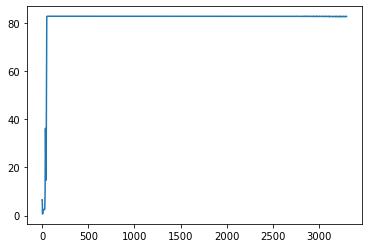

In [28]:
# Let's plot our beautiful results!
plt.plot(Testing_accuracy)